<a href="https://colab.research.google.com/github/Gladybams/predictionchurn/blob/main/PredictionChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction de churn 

## Importation des librairies et fonctions necessaires. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.feature_selection import RFE

In [2]:
data = pd.read_csv("/content/Telco-Customer-Churn.csv")
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


La variable cible est la variable "Churn" qui prend deux variables, donc ici nous faisons face à une classification binaire 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Nombre de valeurs uniques par colonne 
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

### Analyse des données 

In [5]:
# variables categorielles 

categorical_columns = data.nunique()[data.nunique() <5].keys().to_list()
categorical_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [6]:
def bar_plot(a):
  data[a].value_counts(normalize = True).plot(kind = 'bar')
  plt.ylabel('proportion')
  plt.title('Distribution of ' + str(a))
  return plt.show()

In [7]:
interact(bar_plot, a = categorical_columns);

interactive(children=(Dropdown(description='a', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents', '…

Grace au graphe ci dessus, nous pouvons constaster : Qu'il y a environ 30% des clients qui se sont desabonnées. Donc il y a un probleme de de déséquilibre qu'il faut resoudre pour empecher que la performance de notre modele soit impacter. La difference des données est bien repartie entre sexes, la mojorité des clients sont jeune et la proportion des clients celibataire ou en couple sont à peu près equivalents. 

In [8]:
#echantillonnement aléatoire de la variable 'TotalCharges

data['TotalCharges'].sample(15)

3924    4029.95
5986      827.7
6115     7854.9
5450      84.65
3388    3673.15
3619     6129.2
5711       1951
4976     3708.4
4834    1620.45
1849      402.6
5948     5706.2
1889      419.7
3188     365.55
6626     573.75
5228     348.15
Name: TotalCharges, dtype: object

In [9]:
# Variables quantitatives 

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']


In [10]:
def hist_plot(b):
  sns.distplot(data[b], kde=False)
  plt.title('Histogram of '+str(b))
  return plt.show()

In [11]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan).astype(float)

In [12]:
interact(hist_plot, b = numerical_columns );

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

In [13]:
# Coefficient d'asymetrie de la variable 'TotalCharges' : Generalement c'est aux alentours de 0 

data['TotalCharges'].skew()

0.961642499724251

NB : L'exploration des données nous permet de mieux comprendre les données et nous indique quel type de traitement faire avant de passer à la création des modeles.

In [14]:
# Fonction boxplot 

def box_plot(b):
  sns.boxplot(y= data[b])
  plt.title('Boxplot of '+ str(b))
  return plt.show()

interact(box_plot, b = numerical_columns);

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

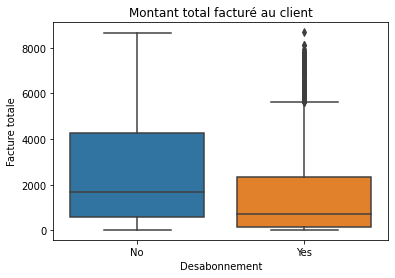

In [15]:
# TotalCharges VS Churn 

sns.boxplot(x='Churn', y='TotalCharges', data=data)
plt.xlabel('Desabonnement')
plt.ylabel('Facture totale')
plt.title('Montant total facturé au client')
plt.show()

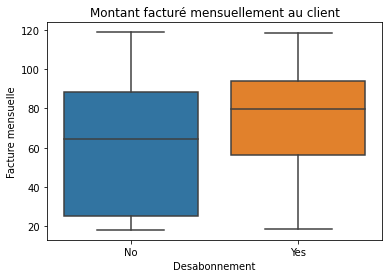

In [16]:
# MonthlyCharges VS Churn 

sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.xlabel('Desabonnement')
plt.ylabel('Facture mensuelle')
plt.title('Montant facturé mensuellement au client')
plt.show()

ici on peut dire les clients se sont desabonnées parce qu'ils sont beaucoup plus facturés. 

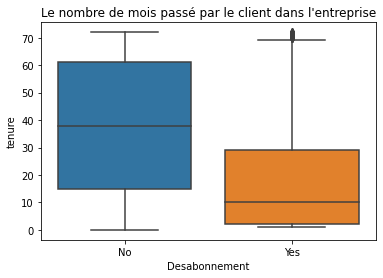

In [17]:
# tenure vs Churn 

sns.boxplot(x='Churn', y='tenure', data=data)
plt.xlabel('Desabonnement')
plt.title("Le nombre de mois passé par le client dans l'entreprise")
plt.show()

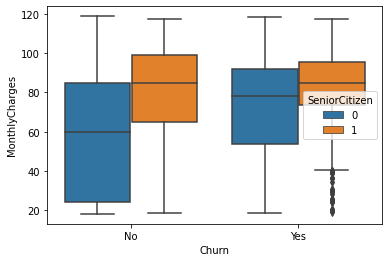

In [18]:
# MontehlyCharges vs Churn by SeniorCitizen

sns.boxplot(x='Churn', y='MonthlyCharges', data=data, hue = 'SeniorCitizen');



Les personnes agées sont beaucoup plus facturés que les jeunes mais malgré reste abonnés plus longtemps 

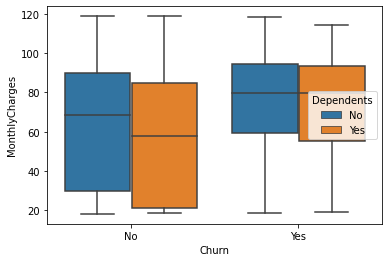

In [19]:
# MonthlyCharges VS Churn by Dependents

sns.boxplot(x='Churn', y='MonthlyCharges', data=data, hue = 'Dependents');

In [20]:
# resume statistique 

data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## PRÉTRAITEMENT DES DONNÉES (DATA PREPROCESSING)

In [21]:
# Gestion des valeurs manquantes 

data1 = data.copy()

data1.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [22]:
# Suppression des valeurs manquantes 

data1.dropna(inplace=True)

data1.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [23]:
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [24]:
# Encodage ds variables binaires 

data1['gender']= data1['gender'].apply(lambda row: 1 if row =='female' else 0)

binary_columns = data1.drop('gender', axis=1).nunique()[data1.drop('gender', axis=1).nunique() < 3].keys().to_list()

binary_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [25]:
for column in binary_columns:
  data1[column] = data1[column].apply(lambda row: 1 if row == 'Yes' else 0)

In [26]:
# Encodage des variables categorielles restantes 

remaining_cat_vars = data1[categorical_columns].nunique()[data1[categorical_columns].nunique() > 2].keys().to_list()

remaining_cat_vars_dummies = pd.get_dummies(data=data1[remaining_cat_vars], columns=remaining_cat_vars, drop_first=True)

In [27]:
# Nouvelle dataframe 

data2 = pd.concat([data1['gender'], data1[binary_columns], remaining_cat_vars_dummies, data1[numerical_columns]], axis=1)

In [28]:
data2.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,29.85,29.85
1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,34,56.95,1889.50
2,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,53.85,108.15
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,45,42.30,1840.75
4,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,70.70,151.65


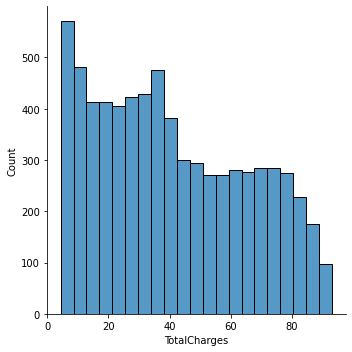

In [29]:
# Transformation de la variable 'TotalCharges'

data2['TotalCharges'] = np.sqrt(data['TotalCharges'])

# Histogramme de la variable transormé

sns.displot(data2['TotalCharges'], kde=False);


In [30]:
# Coefficient d'asymetrie 
data2['TotalCharges'].skew()

0.3089261418986736

Nous allons diviser nos données en 3 parties : entrainement, validation et test. Les données de validations servent à selectionner le meilleur modele 

In [31]:
# Données d'entrainement (60%), validation (20%), test (20%). Stratify : pour s'assurer qu'on a la meme proportion dans dotre varibale cible 

X = data2.drop('Churn', axis =1)

y = data2['Churn']

seed = 1111

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = seed, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed, stratify = y_test)

In [32]:
# Frequence des classes dans y 

pd.DataFrame(y).value_counts(normalize = True)

Churn
0        0.734215
1        0.265785
dtype: float64

In [33]:
# Frequence des classes dans y_train 

pd.DataFrame(y_train).value_counts(normalize = True)

Churn
0        0.734297
1        0.265703
dtype: float64

In [34]:
# Frequence des classes dans y_val

pd.DataFrame(y_val).value_counts(normalize = True)

Churn
0        0.733997
1        0.266003
dtype: float64

In [35]:
# Frequence des classes dans y_test

pd.DataFrame(y_test).value_counts(normalize = True)

Churn
0        0.734186
1        0.265814
dtype: float64

In [36]:
# Resolution du probleme de desequilibre des classes 

X2 = X_train 

X2['Churn'] = y_train.values

minority = X2[X2.Churn ==1]

majority = X2[X2.Churn ==0]

minority_upsampled = resample(minority, replace = True, n_samples = len(majority), random_state=seed)

upsampled = pd.concat([majority, minority_upsampled])

upsampled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6406,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,39,50.65,43.650888,0
6124,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,57,59.30,57.221936,0
4051,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,72,97.70,82.883653,0
3839,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,15,20.05,16.861198,0
2523,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,47,20.25,29.553342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,69.65,8.345658,1
6040,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,70.75,8.411302,1
4212,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,90.60,9.518403,1
508,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,6,80.50,22.424317,1


In [37]:
upsampled['Churn'].value_counts(normalize = True)

1    0.5
0    0.5
Name: Churn, dtype: float64

In [38]:
X_train_up = upsampled.drop('Churn', axis =1)

y_train_up = upsampled['Churn']

In [39]:
# Autres methodes 

In [40]:
majortiy_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state=seed)

downsampled = pd.concat([minority, majortiy_downsampled])

downsampled

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
6908,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,55.35,21.207310,1
1530,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,2,90.00,13.785862,1
3617,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,18,48.35,28.472794,1
6800,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,14,105.95,36.727374,1
3772,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,95.00,9.746794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,71,109.25,87.793508,0
3663,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,9,88.40,28.082023,0
5033,0,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,19.40,4.404543,0
2183,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,50.20,10.452272,0


In [41]:
downsampled['Churn'].value_counts(normalize = True)

1    0.5
0    0.5
Name: Churn, dtype: float64

In [42]:
X_train_down = downsampled.drop('Churn', axis =1)

y_train_down = downsampled['Churn']

In [43]:
# y_train et X_train 

y_train = X_train['Churn']

X_train = X_train.drop('Churn', axis=1)

***Choix possibles : (X_train, y_train), (X_train_up, y_train_up) et (X_train_down, y_train_down)***

In [44]:
train_features = X_train_up 

train_labels = y_train_up

Normalisation 

In [45]:
train_features.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
6406,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,39,50.65,43.650888
6124,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,57,59.30,57.221936
4051,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,72,97.70,82.883653
3839,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,15,20.05,16.861198
2523,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,47,20.25,29.553342


In [46]:
scaler = MinMaxScaler()

mod_scaler = scaler.fit(train_features)
train_features = mod_scaler.transform(train_features)
X_val = mod_scaler.transform(X_val)
X_test = mod_scaler.transform(X_test)

train_features = pd.DataFrame(train_features, columns = X.columns)
X_val = pd.DataFrame(X_val, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [47]:
train_features.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.535211,0.322388,0.442455
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.788732,0.408458,0.595186
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.000000,0.790547,0.883986
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.197183,0.017910,0.140961
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.647887,0.019900,0.283800


## Modelisation 

In [48]:
# Selection des meilleures variables predictrices 

rf = RandomForestClassifier()
rf.fit(train_features, train_labels)
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1032
           1       0.56      0.52      0.54       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.69      1406
weighted avg       0.76      0.77      0.76      1406



Text(0.5, 1.0, 'Importance des variables predictrices')

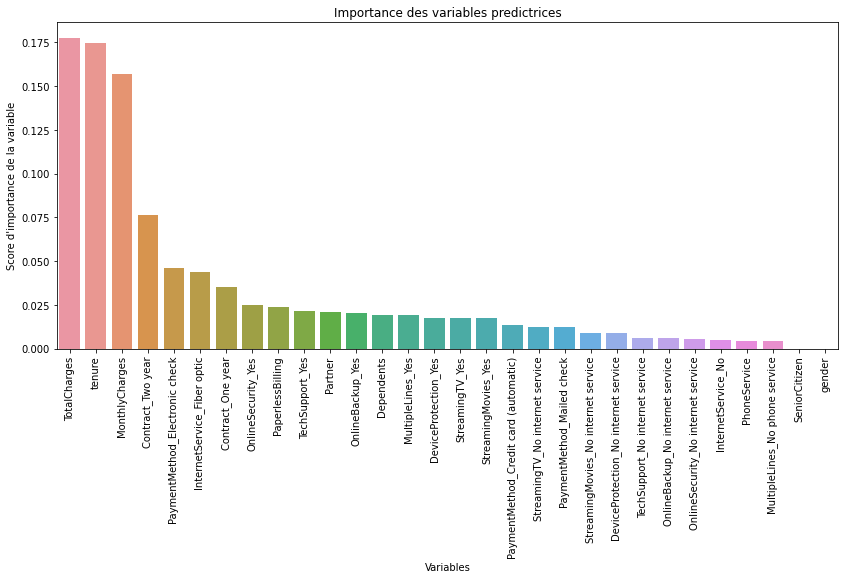

In [49]:
# Importance des variables indépendantes 

plt.figure(figsize=(14, 6)) # pour agrandire le graphe
plt.xticks(rotation=90) 
vars_imp = pd.Series(rf.feature_importances_, index = train_features.columns).sort_values(ascending=False)

sns.barplot(x = vars_imp.index, y = vars_imp)
plt.ylabel("Score d'importance de la variable")
plt.xlabel("Variables")
plt.title("Importance des variables predictrices")

In [50]:
# Affichage de vars_imp

vars_imp 

TotalCharges                             0.177614
tenure                                   0.174629
MonthlyCharges                           0.156986
Contract_Two year                        0.076110
PaymentMethod_Electronic check           0.046287
InternetService_Fiber optic              0.043551
Contract_One year                        0.035459
OnlineSecurity_Yes                       0.025042
PaperlessBilling                         0.023703
TechSupport_Yes                          0.021489
Partner                                  0.021072
OnlineBackup_Yes                         0.020540
Dependents                               0.019373
MultipleLines_Yes                        0.019186
DeviceProtection_Yes                     0.017428
StreamingTV_Yes                          0.017354
StreamingMovies_Yes                      0.017347
PaymentMethod_Credit card (automatic)    0.013245
StreamingTV_No internet service          0.012561
PaymentMethod_Mailed check               0.012308


In [51]:
seuil = 0.009

vars_selected = vars_imp[vars_imp>0.009].index.to_list()

train_features = train_features[vars_selected]

X_val = X_val[vars_selected]

X_test = X_test[vars_selected]

In [52]:
len(vars_selected)

20

### Regression logistique 

In [53]:
# hyperparametres 

param_grid = {'C':[0.001, 0.01, 1, 10, 50, 100, 500]}

# GridSearchCV 

grid_lr_class = GridSearchCV(estimator=LogisticRegression(random_state=seed, max_iter=500), 
                             param_grid=param_grid,
                             scoring='f1',
                             cv=5)

# Training de l'algo 

lr_model = grid_lr_class.fit(train_features, train_labels)

# Meilleur score et hyperparametre 

print(round(lr_model.best_score_, 3))

print(lr_model.best_estimator_)




0.79
LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1111, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [54]:
# Fonction d'évaluation de la performance de l'algorithme

def model_evaluation(model, features, labels):
  pred = model.predict(features)
  print(classification_report(labels, pred))

In [55]:
model_evaluation(lr_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1032
           1       0.51      0.74      0.61       374

    accuracy                           0.75      1406
   macro avg       0.70      0.74      0.71      1406
weighted avg       0.79      0.75      0.76      1406



In [56]:
# RFE : En applicant cette methode on va voir si le modele garde les memes performances lorsqu'on reduit les dimensions 

def model_with_rfe(model):
  rfe_model = RFE(estimator=model, verbose=0)
  rfe_model.fit(train_features, train_labels)
  mask = rfe_model.support_
  reduced_X = train_features.loc[:, mask]
  print(reduced_X.columns)
  return rfe_model

In [57]:
rfe_lr_model = model_with_rfe(lr_model.best_estimator_)

rfe_lr_model

Index(['TotalCharges', 'MonthlyCharges', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'Contract_One year', 'MultipleLines_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'StreamingTV_No internet service'],
      dtype='object')


RFE(estimator=LogisticRegression(C=500, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=500,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=1111, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [58]:
model_evaluation(rfe_lr_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.75      0.61       374

    accuracy                           0.74      1406
   macro avg       0.70      0.75      0.71      1406
weighted avg       0.79      0.74      0.76      1406



### RandomForest 

In [59]:
#Hyperparametres

param_grid_rf = {'n_estimators':[10, 50, 100, 500, 1000], 'max_depth':[3, 5, 10, 20, None]}

#GridSearchCV

grid_rf_class = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), param_grid = param_grid_rf, scoring='f1', cv=5)

#Training 

rf_model = grid_rf_class.fit(train_features, train_labels)

# Meilleur score et hyperparametre

print(round(rf_model.best_score_, 3))

print(rf_model.best_estimator_)




0.909
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)


In [60]:
model_evaluation(rf_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1032
           1       0.57      0.53      0.55       374

    accuracy                           0.77      1406
   macro avg       0.70      0.69      0.69      1406
weighted avg       0.76      0.77      0.76      1406



In [61]:
# Random Forest avec RFE 

rfe_rf_model = model_with_rfe(rf_model.best_estimator_)

rfe_rf_model

Index(['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'InternetService_Fiber optic',
       'Contract_One year', 'OnlineSecurity_Yes', 'PaperlessBilling',
       'StreamingTV_No internet service'],
      dtype='object')


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=20, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=1111,
                                     verbose=0, warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [62]:
model_evaluation(rfe_rf_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1032
           1       0.54      0.53      0.54       374

    accuracy                           0.76      1406
   macro avg       0.69      0.68      0.69      1406
weighted avg       0.75      0.76      0.76      1406



### Reseau de neurones artificiel

In [63]:
# MLPClassifier 

mlp = MLPClassifier(random_state=seed, max_iter=1000)

parameters = {'hidden_layer_sizes':[(50,), (100,), (500,)], 
              'activation':['identity', 'logistic', 'tanh', 'relu'], 
              'learning_rate':['constant', 'invcaling', 'adaptive']}

mlp_cv = GridSearchCV(mlp, parameters, scoring='f1', cv=5, n_jobs=-1)

mlp_cv.fit(train_features, train_labels)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=1000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_stat...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['id

In [64]:
# Meilleur score et hyperparametres 

round(mlp_cv.best_score_, 3)

0.86

In [65]:
mlp_cv.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1111, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [66]:
model_evaluation(mlp_cv.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1032
           1       0.53      0.55      0.54       374

    accuracy                           0.75      1406
   macro avg       0.68      0.69      0.69      1406
weighted avg       0.76      0.75      0.75      1406



### SVM

In [67]:
svm_model = SVC(random_state=seed)

svm_hyp = {'kernel':['linear', 'rbf'], 'C':[0.1, 1.0, 10, 50, 100]}

svm_cv = GridSearchCV(svm_model, svm_hyp, scoring='f1', cv=5)

svm_cv.fit(train_features, train_labels)

print(round(svm_cv.best_score_,3))

print(svm_cv.best_estimator_)

0.855
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1111, shrinking=True,
    tol=0.001, verbose=False)


In [68]:
model_evaluation(svm_cv.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1032
           1       0.49      0.58      0.53       374

    accuracy                           0.73      1406
   macro avg       0.66      0.68      0.67      1406
weighted avg       0.74      0.73      0.74      1406



### Conclusion

Nous avons utiliser les données d'évaluation pour selectionner le meilleur modèle. Ensuite on evalue le meilleur modèle sur le données de test afin de voir sa perfomance sur des nouvelles données.

In [69]:
model_evaluation(lr_model.best_estimator_, X_test, y_test)


              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.54      0.77      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



In [ ]:
from google.colab import drive
drive.mount('/content/drive')